In [1]:
# Importing the libraries and packages
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


Using TensorFlow backend.


In [2]:
# read and parse data 
df = read_csv('Calit2.csv', header=0, squeeze=True)

# merge date time and join with main df
date_time = pd.to_datetime(df['date'] + ' ' + df['time'])

df.drop('date', axis=1, inplace=True)
df.drop('time', axis=1, inplace=True)

cali_df = pd.concat([df, date_time], axis=1)
cali_df.columns = ['flowid', 'count', 'datetime']

# separate inflow and outflow df
out_df = cali_df.loc[cali_df['flowid'] == 7]

in_df = cali_df.loc[cali_df['flowid'] == 9]

out_df.drop('flowid', axis=1, inplace=True)
in_df.drop('flowid', axis=1, inplace=True)

#set index as datetime to support plotting and 
out_df.set_index('datetime', inplace=True)
in_df.set_index('datetime', inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                     count
datetime                  
2005-07-24 00:00:00      0
2005-07-24 00:30:00      0
2005-07-24 01:00:00      0
2005-07-24 01:30:00      0
2005-07-24 02:00:00      0


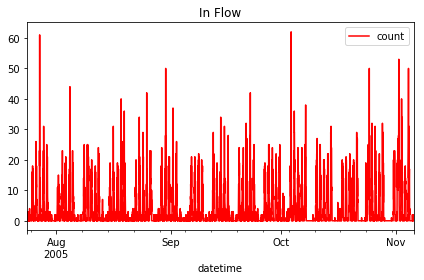

In [3]:
# Let's predict for in flow first

print(in_df.head())

in_df.plot(title='In Flow', color = 'red')
pyplot.tight_layout()
pyplot.show()

#Coverting to numpy arrays
in_df=in_df.values


In [4]:
training_set_scaled = in_df

# Creating a data structure with 24 timesteps and 1 output
X_train_in = []
y_train_in = []
for i in range(24, 5040):
    X_train_in.append(training_set_scaled[i-24:i, 0])
    y_train_in.append(training_set_scaled[i, 0])
X_train_in, y_train_in = np.array(X_train_in), np.array(y_train_in)

# Reshaping
X_train_in = np.reshape(X_train_in, (X_train_in.shape[0], X_train_in.shape[1], 1))



#Building the RNN

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train_in.shape[1], 1)))
regressor.add(Dropout(0.2))

#Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, return_sequences = True))
regressor.add(Dropout(0.2))
#
## Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train_in, y_train_in, epochs = 50, batch_size = 32)








Epoch 1/50
5016/5016 [==============================] - 31s 6ms/step - loss: 27.4518
Epoch 2/50
5016/5016 [==============================] - 27s 5ms/step - loss: 16.8780
Epoch 3/50
5016/5016 [==============================] - 30s 6ms/step - loss: 15.9351
Epoch 4/50
5016/5016 [==============================] - 29s 6ms/step - loss: 15.9974
Epoch 5/50
5016/5016 [==============================] - 29s 6ms/step - loss: 15.5391
Epoch 6/50
5016/5016 [==============================] - 27s 5ms/step - loss: 15.4113
Epoch 7/50
5016/5016 [==============================] - 29s 6ms/step - loss: 15.0866
Epoch 8/50
5016/5016 [==============================] - 29s 6ms/step - loss: 15.0608
Epoch 9/50
5016/5016 [==============================] - 28s 6ms/step - loss: 15.1313
Epoch 10/50
5016/5016 [==============================] - 24s 5ms/step - loss: 14.5244
Epoch 11/50
5016/5016 [==============================] - 23s 5ms/step - loss: 14.9703
Epoch 12/50
5016/5016 [==============================] - 23s 5m

Test MSE: 10.708


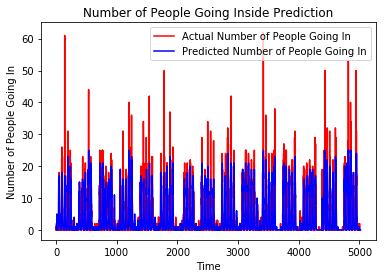

In [5]:
#predicting the results of number of people going in and comparing with the input
from sklearn.metrics import mean_squared_error
predicted_people_in = np.absolute(np.round(regressor.predict(X_train_in),0))
error = mean_squared_error(y_train_in, predicted_people_in)
print('Test MSE: %.3f' % error)
pyplot.plot(y_train_in, color = 'red', label = 'Actual Number of People Going In')
pyplot.plot(predicted_people_in, color = 'blue', label = 'Predicted Number of People Going In')
pyplot.title('Number of People Going Inside Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Number of People Going In')
pyplot.legend()
pyplot.show()

In [51]:
#Predicting the Number of People going inside in next 3 30 mins

X_test_in=X_train_in[5015:5016,:,:]
#X_new=X_train_in[5029:5030,1:,:]
for num in range(1,25):     
    #print(X_test_in)
    #print(regressor.predict(X_test_in))
    X_new=X_test_in[0:1,1:,:]
    print("Number of people going in after",num*30,"mins: ",int(regressor.predict(X_test_in).round()))
    X_new=np.insert(X_new,23,regressor.predict(X_test_in).round(),axis=1)
    X_test_in=X_new

Number of people going in after 30 mins:  0
Number of people going in after 60 mins:  0
Number of people going in after 90 mins:  0
Number of people going in after 120 mins:  0
Number of people going in after 150 mins:  0
Number of people going in after 180 mins:  0
Number of people going in after 210 mins:  0
Number of people going in after 240 mins:  0
Number of people going in after 270 mins:  0
Number of people going in after 300 mins:  1
Number of people going in after 330 mins:  1
Number of people going in after 360 mins:  1
Number of people going in after 390 mins:  1
Number of people going in after 420 mins:  2
Number of people going in after 450 mins:  3
Number of people going in after 480 mins:  5
Number of people going in after 510 mins:  9
Number of people going in after 540 mins:  12
Number of people going in after 570 mins:  14
Number of people going in after 600 mins:  14
Number of people going in after 630 mins:  14
Number of people going in after 660 mins:  14
Number o

                     count
datetime                  
2005-07-24 00:00:00      0
2005-07-24 00:30:00      1
2005-07-24 01:00:00      0
2005-07-24 01:30:00      0
2005-07-24 02:00:00      0


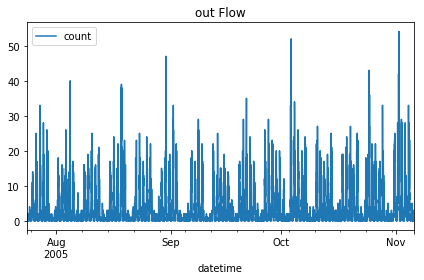

In [7]:
# Let's predict for out flow 
print(out_df.head())
out_df.plot(title='out Flow')
pyplot.tight_layout()
pyplot.show()

out_df=out_df.values

In [8]:
# Feature Scaling
training_set_scaled_out =out_df
# Creating a data structure with 24 timesteps and 1 output
X_train_out = []
y_train_out = []
for i in range(24, 5040):
    X_train_out.append(training_set_scaled_out[i-24:i, 0])
    y_train_out.append(training_set_scaled_out[i, 0])
X_train_out, y_train_out = np.array(X_train_out), np.array(y_train_out)

# Reshaping
X_train_out = np.reshape(X_train_out, (X_train_out.shape[0], X_train_out.shape[1], 1))



# Part 2 - Building the RNN

# Importing the Keras libraries and packages

# Initialising the RNN
regressor_out = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor_out.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train_out.shape[1], 1)))
regressor_out.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor_out.add(LSTM(units = 64, return_sequences = True))
regressor_out.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor_out.add(LSTM(units = 64, return_sequences = True))
regressor_out.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor_out.add(LSTM(units = 64))
regressor_out.add(Dropout(0.2))

# Adding the output layer
regressor_out.add(Dense(units = 1))

# Compiling the RNN
regressor_out.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor_out.fit(X_train_out, y_train_out, epochs = 50, batch_size = 32)


Epoch 1/50
5016/5016 [==============================] - 28s 6ms/step - loss: 22.1082
Epoch 2/50
5016/5016 [==============================] - 26s 5ms/step - loss: 14.4211
Epoch 3/50
5016/5016 [==============================] - 26s 5ms/step - loss: 13.6422
Epoch 4/50
5016/5016 [==============================] - 26s 5ms/step - loss: 13.3120
Epoch 5/50
5016/5016 [==============================] - 25s 5ms/step - loss: 13.4494
Epoch 6/50
5016/5016 [==============================] - 25s 5ms/step - loss: 13.0894
Epoch 7/50
5016/5016 [==============================] - 25s 5ms/step - loss: 13.4469
Epoch 8/50
5016/5016 [==============================] - 25s 5ms/step - loss: 13.2331
Epoch 9/50
5016/5016 [==============================] - 26s 5ms/step - loss: 12.8855
Epoch 10/50
5016/5016 [==============================] - 26s 5ms/step - loss: 13.1158
Epoch 11/50
5016/5016 [==============================] - 25s 5ms/step - loss: 12.7537
Epoch 12/50
5016/5016 [==============================] - 26s 5m

Test MSE: 9.187


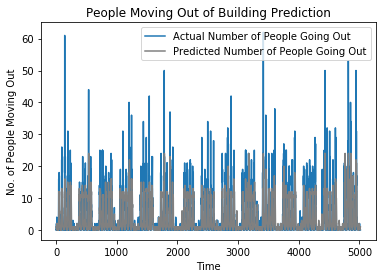

In [9]:
#predicting the results of number of people moving out and comparing with the input

predicted_people_out = np.absolute(np.round(regressor_out.predict(X_train_out),0))
error = mean_squared_error(y_train_out, predicted_people_out)
print('Test MSE: %.3f' % error)
pyplot.plot(y_train_in, label = 'Actual Number of People Going Out')
pyplot.plot(predicted_people_out, color = 'gray', label = 'Predicted Number of People Going Out')
pyplot.title('People Moving Out of Building Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('No. of People Moving Out')
pyplot.legend()
pyplot.show()

In [10]:
#predicted_people = np.absolute(np.round(regressor_out.predict(X_train_out[::0]),0))


In [50]:
#Predicting the Number of People going out in next 3 30 mins
X_test_out=X_train_out[5015:5016,:,:]
#print(regressor_out.predict(X_test_out).round())
#X_new=X_train_in[5029:5030,1:,:]
for num in range(1,25):
    #print(X_test_out)
    #print(regressor_out.predict(X_test_out))
    X_new=X_test_out[0:1,1:,:]
    print("Number of people going out after",num*30,"mins: ",int(regressor_out.predict(X_test_out).round()))
    X_new=np.insert(X_new,23,regressor_out.predict(X_test_out).round(),axis=1)
    X_test_out=X_new
    
    
    
    
    

Number of people going out after 30 mins:  1
Number of people going out after 60 mins:  1
Number of people going out after 90 mins:  1
Number of people going out after 120 mins:  0
Number of people going out after 150 mins:  0
Number of people going out after 180 mins:  0
Number of people going out after 210 mins:  0
Number of people going out after 240 mins:  0
Number of people going out after 270 mins:  0
Number of people going out after 300 mins:  0
Number of people going out after 330 mins:  0
Number of people going out after 360 mins:  0
Number of people going out after 390 mins:  0
Number of people going out after 420 mins:  0
Number of people going out after 450 mins:  0
Number of people going out after 480 mins:  1
Number of people going out after 510 mins:  0
Number of people going out after 540 mins:  1
Number of people going out after 570 mins:  1
Number of people going out after 600 mins:  1
Number of people going out after 630 mins:  2
Number of people going out after 660 